# Modelling - eXtreme Gradient Boost

## Goal:

Using user names and descriptions, I will build a model to predict a person's political leanings, that being liberal or conservative.

### Contents:
- [1. Importing libraries](#1.-Importing-libraries)
- [2. Importing datasets](#2.-Importing-datasets)
- [3. Model hyperparameter tuning](#3.-Model-hyperparameter-tuning)
- [4. Building the model](#4.-Data-Cleaning)
- [5. Model validation and evaluation](#5.-Model-validation-and-evaluation)

## 1. Importing libraries

In [36]:
import pandas as pd
import pleiades as ple
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pickle
pd.options.display.max_columns=110
pd.options.display.max_rows=300

## 2. Importing datasets

In [37]:
import_path = r'..\data\#michellewilliams_users_clean.csv'
df = pd.read_csv(import_path, index_col=0)

import_path = r'..\data\replies_to_jk_rowling_users_clean.csv'
df2 = pd.read_csv(import_path, index_col=0)

In [38]:
df.head()

,name_and_description,conservative
0,Boris Is My Prime Minister ✡ ️ 🇬🇧,1.0
1,🇺🇸 🇺🇸 Red Blooded All American 🌾 Heartland bo...,1.0
2,Indian singer Army brat Muay Thai panda Horse ...,0.0
3,Christian SC Gamecocks College Football Outdoo...,1.0
4,Mother of Amma to love my kids love my grandki...,1.0


In [39]:
df = df.fillna('')
df2 = df2.fillna('')

In [40]:
X = df['name_and_description']
X_val = df2['name_and_description']
y = df['conservative'].values
y_val = df2['conservative'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)
sebas = ple.Sebastian()

## 3. Model hyperparameter tuning

In [16]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('xgb_class', xgb.XGBClassifier())
])
params = {
    'tvec__stop_words': ['english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [.3, .6, .9],
    'tvec__min_df': [1, 3, 7],
    'tvec__max_features': [2000, 5000, 10000],
    'tvec__token_pattern': [r'([^\s]+)'],
    'xgb_class__max_depth': [4, 5, 6],
    'xgb_class__subsample': [.8, 1],
    'xgb_class__colsample_bytree': [.8, 1]
}

gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
# best score: 0.8081145584725536
print('best score:', gs.best_score_)
# best params: tvec: max_df=0.3, max_features=5000, min_df=1, ngram_range=(1, 1), stop_words='english', token_pattern='([^\s]+)' xgb_class: colsample_bytree=1, max_depth=6, subsample=1
print('best params:', sebas.get_params(gs.best_params_))
print()

best score: 0.8081145584725536
best params: tvec: max_df=0.3, max_features=5000, min_df=1, ngram_range=(1, 1), stop_words='english', token_pattern='([^\s]+)' xgb_class: colsample_bytree=1, max_depth=6, subsample=1



## 4. Building the model

In [43]:
tvec = TfidfVectorizer(max_df=0.3, max_features=5000, min_df=1, ngram_range=(1, 1), stop_words='english', token_pattern='([^\s]+)')
X_train = tvec.fit_transform(X_train)
feature_names = [x.replace(' ', '_') for x in tvec.get_feature_names()]
X_train = pd.DataFrame(X_train.toarray(), columns=feature_names)
X_test = tvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=feature_names)
X_val = tvec.transform(X_val)
X_val = pd.DataFrame(X_val.toarray(), columns=feature_names)

In [44]:
print('TfidfVectorizer:')
print(X_train.sum().sort_values(ascending=False)[:10])

TfidfVectorizer:
🇺🇸       175.936716
️        170.340473
maga     116.087153
trump    112.581509
love     107.452647
⭐         92.887346
life      76.834655
❤         67.516191
god       66.767148
kag       63.956198
dtype: float64


In [45]:
xgb_class = xgb.XGBClassifier(colsample_bytree=1, max_depth=6, subsample=1)
xgb_class.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
pickle.dump(xgb_class, open(r'..\pickles\model_xgb.sav', 'wb'))

## 5. Model validation and evaluation

In [47]:
with open(r'..\pickles\model_xgb.sav', 'rb') as f:
    xgb_class = pickle.load(f)

In [48]:
y_pred = xgb_class.predict(X_test)
y_pred2 = xgb_class.predict(X_val)
y_prob = xgb_class.predict_proba(X_test)
y_prob2 = xgb_class.predict_proba(X_val)

In [49]:
sebas = ple.Sebastian()

### Plot most important features

In [50]:
print('most_important_features:', sebas.get_features(X_train, xgb_class.feature_importances_, order='dsc'))
print()

most_important_features: {'maga': 0.19340111, 'conservative': 0.057176616, 'jesus': 0.024534458, '🇺🇸': 0.023266438, 'christian': 0.022261452, 'god': 0.020626942, 'kag': 0.018831542, '⭐': 0.018538907, '🌈': 0.016781664, 'resist': 0.016684998, '🌊': 0.0162693, 'resistance': 0.013048213, 'patriot': 0.011197153, 'wwg1wga': 0.01049811, '2a': 0.010464876, '❌': 0.009883616, 'christ': 0.009521365, '💚': 0.009312537, 'feminist': 0.009013554, 'america': 0.008491555, 'writer': 0.008301027, 'trump': 0.007970694, 'government': 0.007923979, 'blue': 0.0077234255, 'catholic': 0.007657248, 'en': 0.007471807, '\u200d': 0.0071396315, 'genflynn': 0.007028629, '✝': 0.006958363, '✨': 0.0066527687, 'tv': 0.00657151, 'girl': 0.0064472375, 'good': 0.0062424056, '2020': 0.00623172, 'followed': 0.0062276497, 'film': 0.0060848594, 'journalist': 0.0059425393, 'activist': 0.005911696, 'choice': 0.0058778995, 'vote': 0.0058205, 'producer': 0.005747213, 'liberals': 0.0055626277, 'lover': 0.005562337, 'pro': 0.0054686936

C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55357 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 56474 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 10060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 55356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 57098 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\admin\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:211: 

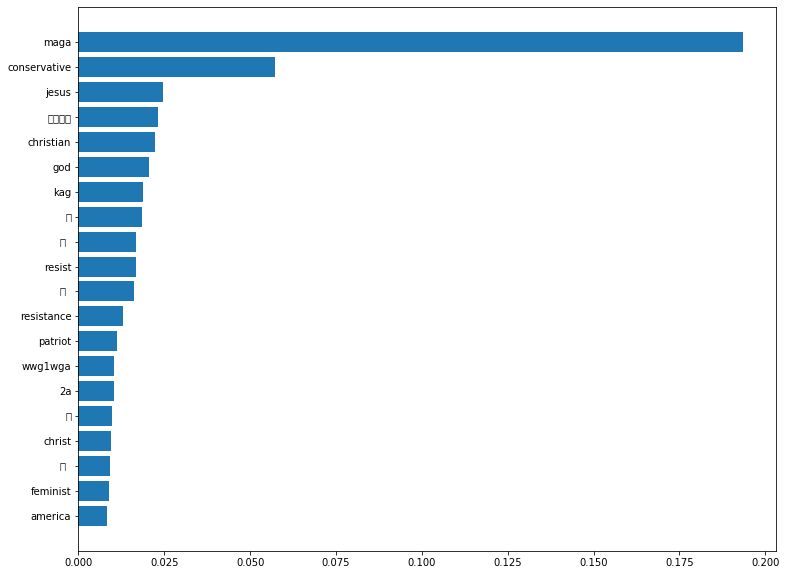

In [51]:
sebas.plot_importances(max_features=20, figsize=(12.5, 10))

### Run model on test and validation set

In [53]:
print(classification_report(y_test, y_pred, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.75      0.97      0.85      1169
         1.0       0.94      0.60      0.73       927

    accuracy                           0.81      2096
   macro avg       0.85      0.78      0.79      2096
weighted avg       0.84      0.81      0.80      2096



In [54]:
print(confusion_matrix(y_test, y_pred))

[[1135   34]
 [ 374  553]]


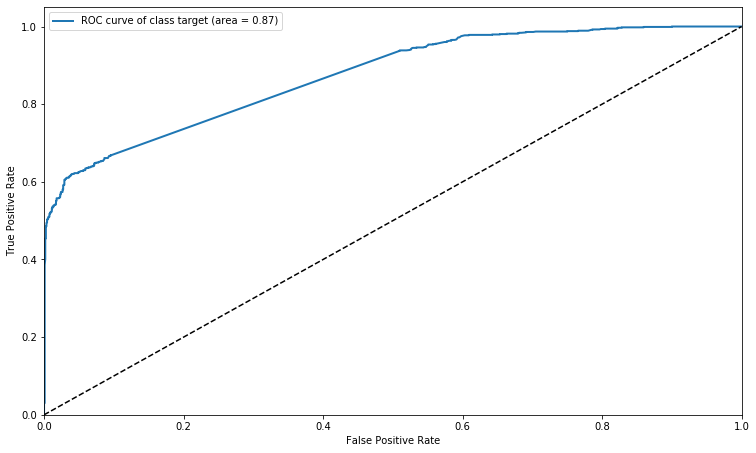

In [55]:
yuri = ple.Yuri()

yuri.plot_roc(y_test, y_prob, figsize=(12.5, 7.5))

In [56]:
print(classification_report(y_val, y_pred2, output_dict=False))

              precision    recall  f1-score   support

         0.0       0.86      0.99      0.92       781
         1.0       0.82      0.25      0.38       166

    accuracy                           0.86       947
   macro avg       0.84      0.62      0.65       947
weighted avg       0.85      0.86      0.83       947



In [57]:
print(confusion_matrix(y_val, y_pred2))

[[772   9]
 [125  41]]


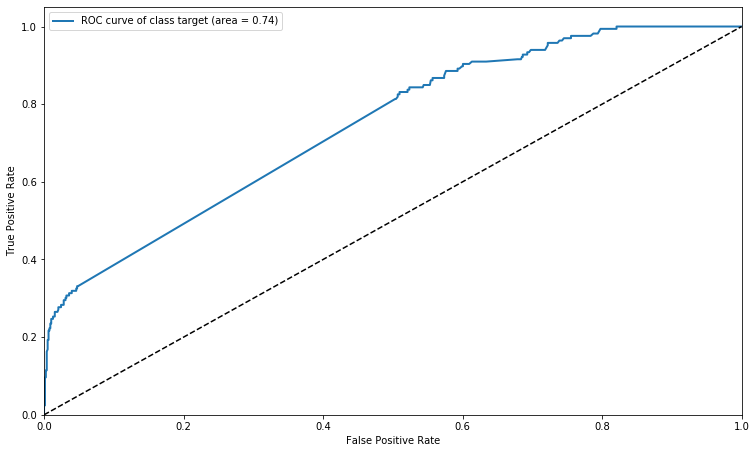

In [58]:
yuri = ple.Yuri()

yuri.plot_roc(y_val, y_prob2, figsize=(12.5, 7.5))

### Conclusion

- The model proved to be reasonably accurate in predicting the political leanings of a person, with an accuracy of 81% on the test dataset and 86% on the validation dataset. This shows that the model is not overfitted.
- The precision of the model remains high across both datasets.
- Many of the terms that the model used to predict a person's political leanings are dependent on the current political climate in the United States, which are likely to change every 4 years.
- It also needs to be kept in mind that the model was trained on an English speaking, mostly American subset of the twitter population. While it appears to be reasonably accurate on English twitter on European topics, it may not be as accurate in less westernized English speaking countries like Singapore.